In [1]:
def get_winner(board):
        # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                return [0,0,1]
            else:
                return [1,0,0]
    return [0,1,0]
    

def is_valid_tic_tac_toe(board):
    # Check that the board has exactly 9 elements
    if len(board) != 9:
        return False
    
    # Count the number of 'x' and 'o' on the board
    count_x = board.count('x')
    count_o = board.count('o')
    
    # Check that the difference in count between 'x' and 'o' is 0 or 1
    if abs(count_x - count_o) > 1:
        return False
    
    # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                x_wins = True
            else:
                o_wins = True
    
    # Check if both 'x' and 'o' won or if neither won
    if x_wins and o_wins or (not x_wins and not o_wins):
        return False
    
    # Check that the board is a valid final board configuration
    if (x_wins and count_x != count_o + 1) or (o_wins and count_x != count_o):
        return False
    # All checks have passed, so the board is valid
    return True
  

In [2]:
def generate_tic_tac_toe_configs():
    valid_configs = []
    winners = []
    
    # Generate all possible configurations of the board
    for i in range(3**9):
        board = []
        for j in range(9):
            symbol = ''
            if i % 3 == 0:
                symbol = 'x'
            elif i % 3 == 1:
                symbol = 'o'
            board.append(symbol)
            i //= 3
        
        # Check if the configuration is valid
        if is_valid_tic_tac_toe(board):
            valid_configs.append(board)
            winners.append(get_winner(board))
    
    return valid_configs, winners

In [3]:
boards, winners = generate_tic_tac_toe_configs()
print("boards: ", boards[1:5])
print("winners: ",  winners[1:5])
print(len(boards))
print(len(winners))

boards:  [['o', 'x', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['x', 'o', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', '', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', 'o', '', 'o', 'o', 'x', 'x', 'x', 'x']]
winners:  [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
942
942


In [4]:
import numpy as np
from qiskit import *

In [5]:
# tic_tac_toe_field = ['x','x','o','','o','x','o','','']
def encode_data(tic_tac_toe_field, circuit):
    data_g = [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in tic_tac_toe_field ]
    for entry, index in zip(data_g, range(len(data_g))):
        circuit.rx(entry * 2 * np.pi / 3, index)
                   
    return circuit

In [6]:
def add_single_qubit_gates(params, circuit):
    red_qubits = [0,1,5]
    blu_qubits = [2,3]
    yellow_qubits = [4,6]
    green_qubits = [7, 8]
    # param=[red, blu, yellow, green]
    # red
    for i in red_qubits:
        circuit.rx(params[0],i)
        circuit.ry(params[1],i)
    # blu
    for i in blu_qubits:
        circuit.rx(params[2],i)
        circuit.ry(params[3],i)
    # yellow 
    for i in yellow_qubits:
        circuit.rx(params[4],i)
        circuit.ry(params[5],i)
    # green
    for i in green_qubits:
        circuit.rx(params[6],i)
        circuit.ry(params[7],i)
    return circuit

In [7]:
def add_two_qubit_gates(params, circuit):
    red_qubits = [0,1,5]
    blu_qubits = [2,3]
    yellow_qubits = [4,6]
    green_qubits = [7, 8]
    # param=[red, blu, yellow, green]
    # red
    circuit.cry(params[0],0,3)
    circuit.cry(params[0],1,4)
    # blu
    circuit.cry(params[1],2,5)
    circuit.cry(params[1],3,4)
    # yellow
    circuit.cry(params[2],6,3)
    # green 
    circuit.cry(params[3],7,4)
    circuit.cry(params[3],7,6)
    circuit.cry(params[3],8,5)
    
    return circuit

In [8]:
def predict(data, params):
    circ = QuantumCircuit(9)
    circ.params = params
    encode_data(data, circ)
    circ.barrier()
    add_single_qubit_gates(params[0:8], circ)
    circ.barrier()
    add_two_qubit_gates(params[8:12], circ)

    estimator = Estimator()
    circuits = (
        circ,
        circ,
        circ
    )
    observables = (
        SparsePauliOp("ZIZIIIZIZ") / 4.0,
        SparsePauliOp("IZIZIZIZI") / 4.0,
        SparsePauliOp("IIIIZIIII")
    )

    job = estimator.run(circuits, observables)
    result = job.result()
    results = result.values.tolist()
    exp_val_o = results[0]
    exp_val_draw = results[2]
    exp_val_x = results[1]

    return [exp_val_o, exp_val_draw, exp_val_x]

# Define the loss function
def l2_loss(output, target):
    output, target = np.array(output), np.array(target)
    return np.sum(np.abs(output - target)**2)

In [9]:
# Define the optimizer
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
from qiskit.algorithms.optimizers import SPSA


# Define the cost function to be minimized by the optimizer
def cost_function(params, data, labels):
    y = labels
    # TODO: Calculate the cost and return them
    cost = 0
    
    for i in range(len(data)):
        output = predict(data[i],params)
        output = np.abs(output)
        #pos = np.argmax(np.abs(output))
        #output = np.zeros(3)
        #output[pos] = 1
        cost += l2_loss(output, y[i])
    return cost/len(data)

# Initialize the parameters
params = np.random.rand(12)*2*np.pi

# Train the circuit
print('Initial parameters:', params)


# Check the qiskit docs to figure out how to start an optimizer

Initial parameters: [5.05514012 0.72909074 2.35019614 3.03368527 2.81679371 1.49307648
 1.23801128 3.19115648 5.08149061 5.89247446 1.76557578 2.89122655]


In [10]:
x = boards
y = winners

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.7)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)

print("Example train data: ", x_train[17], y_train[17])

Example train data:  ['' 'o' 'o' 'o' '' 'x' 'x' 'x' 'x'] [0 0 1]


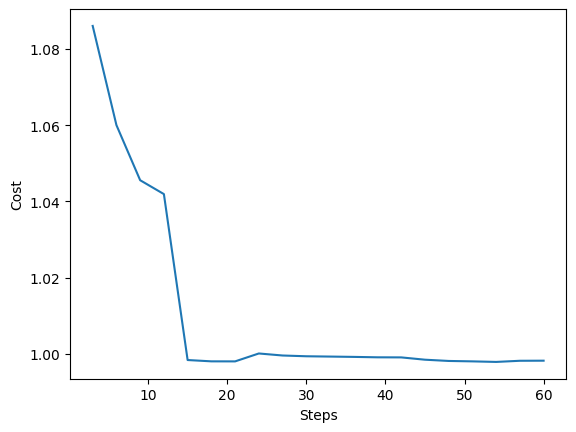

In [12]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

estimator = Estimator()
log = OptimizerLog()
optimizer = SPSA(maxiter=20, callback=log.update)
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(variational,x_train, y_train)
result = optimizer.minimize(fun=objective_function,x0= params)
opt_var = result.x
opt_val = result.fun
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [13]:
preds = []
for i in range(len(x_test)):
    preds.append(predict(x_test[i],opt_var))

In [14]:
preds_1 =[]
y_test1 = []
for i in range(len(preds)):
    pos = np.argmax(preds[i])
    preds[i] = list(-1*np.ones(3))
    preds[i][pos] = 1
    preds_1.append(pos)
    pos1 = np.argmax(y_test[i])
    y_test1.append(pos1)
preds = np.array(preds)

In [15]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
f1_score(y_test1,preds_1, average='weighted')


0.33267130368778547

In [16]:
confusion_matrix(y_test1,preds_1)

array([[22, 55, 21],
       [ 0,  0,  0],
       [58, 79, 48]], dtype=int64)